# Automatyczne Uczenie Maszynowe

## Projekt 1

Marta Balcerzak, Michał Dębski, Maciej Koczorowski


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer

from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score, roc_curve, balanced_accuracy_score, mean_squared_error

import numpy as np
import pandas as pd

from sklearn import set_config

set_config(transform_output = "pandas")

In [ ]:
 pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV
import optuna

In [ ]:
pip install openml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.8 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=61abac22efcb3c49c7e0cf2f29f4ca381f447a9275974cd6b7e3ee2ed6ad9799
  Stored in directory: /root/.cache/pip/wheels/a9/ac/cf/c2919807a5c623926d217c0a18eb5b457e5c19d242c3b5963a
Successfully built liac-arff


### Dane - wczytanie, preprocessing

In [ ]:
from time import perf_counter

In [ ]:
import openml

dataset_ids = {
    "diabetes": 37, # diabetes, https://www.openml.org/search?type=data&sort=runs&status=active&id=37
    "pizza": 1444, # PizzaCutter3, https://www.openml.org/search?type=data&status=active&id=1444
    "climate": 1467, # climate-model-simulation-crashes, https://www.openml.org/search?type=data&status=active&sort=runs&id=1467
    "spambase": 44, # spambase, https://www.openml.org/search?type=data&sort=runs&status=active&id=44
    "pc1": 1068, # pc1, https://www.openml.org/search?type=data&sort=runs&status=active&id=1068
    # "scene": 312, # scene, https://www.openml.org/search?type=data&status=active&id=312
    "credit": 29, # credit-approval, https://www.openml.org/search?type=data&status=active&id=29
}

datasets = {}
dataframes = {}

for name, did in dataset_ids.items():
    print(f"Fetching {name} (id={did})...")
    ds = openml.datasets.get_dataset(did)
    X, y, _, _ = ds.get_data(dataset_format="dataframe")
    datasets[name] = ds
    dataframes[name] = X

print("Datasets loaded:", list(dataframes.keys()))

Fetching diabetes (id=37)...
Fetching pizza (id=1444)...
Fetching climate (id=1467)...
Fetching spambase (id=44)...
Fetching pc1 (id=1068)...
Fetching credit (id=29)...
Datasets loaded: ['diabetes', 'pizza', 'climate', 'spambase', 'pc1', 'credit']


In [ ]:
data = {}
targets = {}

for idx, key in enumerate(dataframes):
  df = dataframes[key]
  p = df.shape[1]
  targets[f"y{idx+1}"] = df.loc[:, df.columns[p-1]]
  data[f"X{idx+1}"] = df.drop(df.columns[p-1], axis=1)


In [ ]:
data_train = {}
targets_train = {}
data_test = {}
targets_test = {}
i = 1
for X, y in zip(data.values(), targets.values()):
  data_train[f"X{i}"], data_test[f"X{i}"], targets_train[f"y{i}"], targets_test[f"y{i}"] = train_test_split(X, y, test_size=0.25, random_state=11)
  i += 1

In [ ]:
numerical_transformer1 = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])
numerical_transformer2 = Pipeline(steps = [
    ('imputer', KNNImputer(n_neighbors = 3)),
    ('scaler', StandardScaler())
])
categorical_transformer1 = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

In [ ]:
preprocessor1 = ColumnTransformer([
    ('num_pre', numerical_transformer1, make_column_selector(dtype_include=np.number)),
    ('cat_pre', categorical_transformer1, make_column_selector(dtype_include=np.object_))
])
preprocessor2 = ColumnTransformer([
    ('num_pre', numerical_transformer2, make_column_selector(dtype_include=np.number)),
    ('cat_pre', categorical_transformer1, make_column_selector(dtype_include=np.object_))
])


In [ ]:
skew_pos_data=list(data_train["X4"].loc[:, data_train["X4"].skew() > 1].dtypes.index)
X4_train_new=data_train["X4"]
X4_train_new[skew_pos_data] = np.log1p(data_train["X4"][skew_pos_data])
X4_test_new=data_test["X4"]
X4_test_new[skew_pos_data] = np.log1p(X4_test_new[skew_pos_data])
data_train["X4"] = X4_train_new
data_test["X4"] = X4_test_new

In [ ]:
selector = make_column_selector(dtype_include=['object', 'category'])
selected_cols = selector(data["X6"])
X6_train_new = data_train["X6"]
skew_neg_data=list(data_train["X6"].drop(selected_cols,axis=1).loc[:, data_train["X6"].skew(numeric_only=True) < -1].dtypes.index)
X6_train_new[skew_neg_data] = np.log1p(data_train["X6"][skew_neg_data])
X6_test_new = data_test["X6"]
X6_test_new[skew_neg_data] = np.log1p(data_test["X6"][skew_neg_data])

data_train["X6"] = X6_train_new
data_test["X6"] = X6_test_new

In [ ]:
skew_pos_data=list(data_train["X5"].loc[:, data_train["X5"].skew() > 1].dtypes.index)
X5_train_new=data_train["X5"]
X5_train_new[skew_pos_data] = np.log1p(data_train["X5"][skew_pos_data])
X5_test_new=data_test["X5"]
X5_test_new[skew_pos_data] = np.log1p(data_test["X5"][skew_pos_data])

data_train["X5"] = X5_train_new
data_test["X5"] = X5_test_new

In [ ]:
skew_pos_data=list(data_train["X2"].loc[:, data_train["X2"].skew() > 1].dtypes.index)
X2_train_new=data_train["X2"]
X2_train_new[skew_pos_data] = np.log1p(data_train["X2"][skew_pos_data])
X2_test_new=data_test["X2"]
X2_test_new[skew_pos_data] = np.log1p(data_test["X2"][skew_pos_data])

data_train["X2"] = X2_train_new
data_test["X2"] = X2_test_new

### Elastic Net

In [ ]:
lm_pipeline = Pipeline([
    ('pre',preprocessor1),
    ('lm', LogisticRegression(penalty='elasticnet', C=1, solver='saga', l1_ratio=0.5,max_iter=100000, n_jobs=-1))
])

Siatkę hiperparametrów dobieramy korzystając z artykulu.

In [ ]:
params_lm_rs = {
    'lm__C': np.logspace(-10,10,1000),
    'lm__l1_ratio': np.linspace(0,1,1000)
    } # parametry tylko dla RandomizedSearch (dokładniejsza siatka)


params_lm_gs = {
    'lm__C': np.logspace(-10,10,10),
    'lm__l1_ratio': np.linspace(0,1,10)
    } # parametry tylko dla GridSearch (prostsze obliczeniowo)


rand_pipeline_lm = RandomizedSearchCV(
    estimator=lm_pipeline,
    param_distributions=params_lm_rs,
    n_iter=30, # ile razy losujemy
    cv=3,
    scoring='roc_auc',
    random_state=13 # warto, zeby wyniki sie powtarzaly
)

grid_pipeline_lm = GridSearchCV(lm_pipeline,
                             cv = 7,
                             scoring='roc_auc',
                             param_grid = params_lm_gs,
                             n_jobs = -1)




## Ile potrzeba iteracji?
#### 1. RandomSearch

In [ ]:
iters = [x for x in range(10, 61, 5)]
results = []
idx = 1

for iteration in iters:
  pipeline = RandomizedSearchCV(
    estimator=lm_pipeline,
    param_distributions=params_lm_rs,
    n_iter=iteration,
    cv=3,
    scoring='roc_auc',
    random_state=13
  )
  print(f"Starting RandomSearch for {iteration} iterations...")
  start = perf_counter()
  pipeline.fit(data_train["X1"], targets_train["y1"])
  end = perf_counter()
  print(f"RandomSearch for {iteration} iterations completed in {end - start:.2f} seconds.")
  score = pipeline.best_score_
  results.append(pipeline.best_score_)

  print(f"Obtained:  AUC - {score:.4f}")


Starting RandomSearch for 10 iterations...
RandomSearch for 10 iterations completed in 1.27 seconds.
Obtained:  AUC - 0.8155
Starting RandomSearch for 15 iterations...
RandomSearch for 15 iterations completed in 1.71 seconds.
Obtained:  AUC - 0.8155
Starting RandomSearch for 20 iterations...
RandomSearch for 20 iterations completed in 4.49 seconds.
Obtained:  AUC - 0.8191
Starting RandomSearch for 25 iterations...
RandomSearch for 25 iterations completed in 3.24 seconds.
Obtained:  AUC - 0.8191
Starting RandomSearch for 30 iterations...
RandomSearch for 30 iterations completed in 3.55 seconds.
Obtained:  AUC - 0.8191
Starting RandomSearch for 35 iterations...
RandomSearch for 35 iterations completed in 3.90 seconds.
Obtained:  AUC - 0.8191
Starting RandomSearch for 40 iterations...
RandomSearch for 40 iterations completed in 5.02 seconds.
Obtained:  AUC - 0.8191
Starting RandomSearch for 45 iterations...
RandomSearch for 45 iterations completed in 5.14 seconds.
Obtained:  AUC - 0.8191


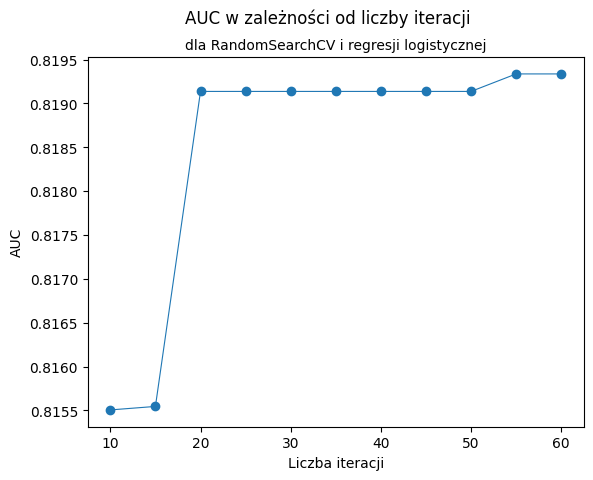

In [ ]:
import matplotlib.pyplot as plt

plt.plot(iters, results, lw = 0.8)
plt.scatter(iters, results)
plt.xlabel("Liczba iteracji")
plt.ylabel("AUC")
plt.suptitle("AUC w zależności od liczby iteracji")
plt.title("dla RandomSearchCV i regresji logistycznej", fontdict={"size":10})
plt.show()

#### 2. Optuna

In [ ]:
import optuna
from sklearn.base import clone
from sklearn.model_selection import cross_val_score

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
iters = [x for x in range(10, 201, 10)]
results = []

def objective(trial, X, y, base_pipeline):

    lm_C = trial.suggest_float("C", 1e-10, 1e10, log=True)
    lm_ratio = trial.suggest_float("l1_ratio", 1e-10, 1)

    pipeline = clone(base_pipeline)

    pipeline.set_params(lm__C = lm_C, lm__l1_ratio = lm_ratio)

    scores = cross_val_score(pipeline, X, y, cv=3, scoring="roc_auc", n_jobs=-1)
    return scores.mean()

for iter in iters:
  print(f"Starting Optuna study for {iter} iterations...")
  start = perf_counter()
  study = optuna.create_study(direction="maximize", study_name=f"optuna_n_{iter}")

  study.optimize(lambda trial: objective(trial, data_train["X1"], targets_train["y1"], lm_pipeline), n_trials=iter)
  end = perf_counter()
  print(f"Optuna study for dataset {iter} iterations completed in {end - start:.1f} seconds.")
  score = study.best_value
  results.append(score)

  print(f"Obtainted: AUC - {score:.4f}")


Starting Optuna study for 10 iterations...
Optuna study for dataset 10 iterations completed in 3.6 seconds.
Obtainted: AUC - 0.8194
Starting Optuna study for 20 iterations...
Optuna study for dataset 20 iterations completed in 2.2 seconds.
Obtainted: AUC - 0.8155
Starting Optuna study for 30 iterations...
Optuna study for dataset 30 iterations completed in 2.9 seconds.
Obtainted: AUC - 0.8186
Starting Optuna study for 40 iterations...
Optuna study for dataset 40 iterations completed in 3.8 seconds.
Obtainted: AUC - 0.8229
Starting Optuna study for 50 iterations...
Optuna study for dataset 50 iterations completed in 5.7 seconds.
Obtainted: AUC - 0.8195
Starting Optuna study for 60 iterations...
Optuna study for dataset 60 iterations completed in 5.8 seconds.
Obtainted: AUC - 0.8251
Starting Optuna study for 70 iterations...
Optuna study for dataset 70 iterations completed in 7.6 seconds.
Obtainted: AUC - 0.8246
Starting Optuna study for 80 iterations...
Optuna study for dataset 80 itera

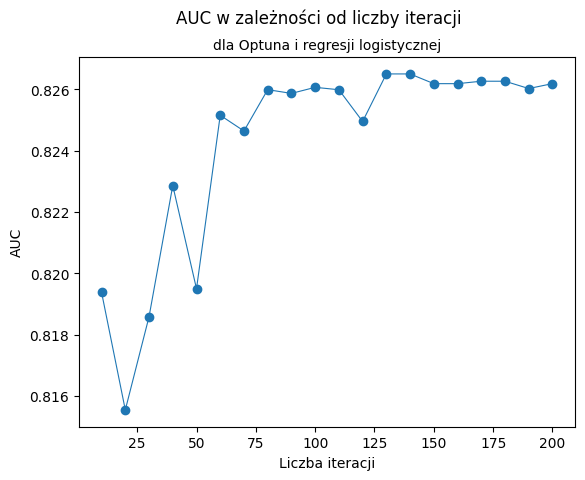

In [ ]:
import matplotlib.pyplot as plt

plt.plot(iters, results, lw = 0.8)
plt.scatter(iters, results)
plt.xlabel("Liczba iteracji")
plt.ylabel("AUC")
plt.suptitle("AUC w zależności od liczby iteracji")
plt.title("dla Optuna i regresji logistycznej", fontdict={"size":10})
plt.show()

In [ ]:
for idx in range(1, len(dataframes)+1):
  print(f"Dataset X{idx} has {data[f"X{idx}"].shape[1]} columns")

Dataset X1 has 8 columns
Dataset X2 has 37 columns
Dataset X3 has 20 columns
Dataset X4 has 57 columns
Dataset X5 has 21 columns
Dataset X6 has 15 columns


In [ ]:
lm_random_results = {}
lm_random_best_params = {}

for idx in range(1, len(datasets) + 1):
  print(f"Starting RandomSearch for dataset X{idx}...")
  start = perf_counter()
  rand_pipeline_lm.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])
  end = perf_counter()
  print(f"RandomSearch for dataset X{idx} completed in {end - start:.2f} seconds.")

  lm_random_results[f"X{idx}"] = rand_pipeline_lm.cv_results_
  lm_random_best_params[f"X{idx}"] = rand_pipeline_lm.best_params_

Starting RandomSearch for dataset X1...
RandomSearch for dataset X1 completed in 3.00 seconds.
Starting RandomSearch for dataset X2...
RandomSearch for dataset X2 completed in 158.66 seconds.
Starting RandomSearch for dataset X3...
RandomSearch for dataset X3 completed in 32.80 seconds.
Starting RandomSearch for dataset X4...
RandomSearch for dataset X4 completed in 401.49 seconds.
Starting RandomSearch for dataset X5...
RandomSearch for dataset X5 completed in 72.10 seconds.
Starting RandomSearch for dataset X6...
RandomSearch for dataset X6 completed in 4.43 seconds.


In [ ]:
lm_random_results_full = []
for idx in range(1, len(dataframes)):
  lm_random_results_full.append(lm_random_results[f"X{idx}"]["mean_test_score"])
lm_random_means = np.mean(lm_random_results_full, axis=0)

In [ ]:
theta = lm_random_results["X1"]['params'][np.argmax(lm_random_means)]

In [ ]:
theta

{'lm__l1_ratio': np.float64(0.8588588588588588),
 'lm__C': np.float64(0.675818116816111)}

To jest $\theta^*$ z artykułu, dla funkcji agregującej $g(x) = \text{mean}(x)$ [bierzemy wyniki na zbiorze X1, bo siatka hiperparamentrów jest taka sama dla każdego zbioru]

In [ ]:
lm_random_results_scaled = []
for element in lm_random_results_full:
  lm_random_results_scaled.append((element - np.mean(element))/np.std(element))

In [ ]:
theta_scaled = lm_random_results["X1"]['params'][np.argmax(np.mean(lm_random_results_scaled, axis=0))]

In [ ]:
theta_scaled

{'lm__l1_ratio': np.float64(0.8588588588588588),
 'lm__C': np.float64(0.675818116816111)}

$\theta^*$ po standaryzacji AUC między zbiorami

### Optymalizacja bayesowska dla Elastic Net

In [ ]:
import optuna
from sklearn.base import clone
from sklearn.model_selection import cross_val_score

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
def objective(trial, X, y, base_pipeline):

    lm_C = trial.suggest_float("C", 1e-10, 1e10, log=True)
    lm_ratio = trial.suggest_float("l1_ratio", 1e-10, 1)

    pipeline = clone(base_pipeline)

    pipeline.set_params(lm__C = lm_C, lm__l1_ratio = lm_ratio)

    scores = cross_val_score(pipeline, X, y, cv=3, scoring="roc_auc", n_jobs=-1)
    return scores.mean()

studies = {}
results = {}

for idx in range(1, len(data_train) + 1):
    print(f"Starting Optuna study for dataset X{idx}...")
    start = perf_counter()
    study = optuna.create_study(direction="maximize", study_name=f"lm_optuna_{idx}")

    study.optimize(lambda trial: objective(trial, data_train[f"X{idx}"], targets_train[f"y{idx}"], lm_pipeline), n_trials=60)
    end = perf_counter()
    print(f"Optuna study for dataset X{idx} completed in {end - start:.1f} seconds.")

    studies[f"lm_study_{idx}"] = study
    results[f"lm_best_params_{idx}"] = study.best_params


Starting Optuna study for dataset X1...
Optuna study for dataset X1 completed in 8.0 seconds.
Starting Optuna study for dataset X2...
Optuna study for dataset X2 completed in 209.3 seconds.
Starting Optuna study for dataset X3...
Optuna study for dataset X3 completed in 27.4 seconds.
Starting Optuna study for dataset X4...
Optuna study for dataset X4 completed in 732.8 seconds.
Starting Optuna study for dataset X5...
Optuna study for dataset X5 completed in 117.4 seconds.
Starting Optuna study for dataset X6...
Optuna study for dataset X6 completed in 8.2 seconds.


In [ ]:
scores = []
for names,vals in results.items():
  tmp = []
  c= vals['C']
  l1 = vals['l1_ratio']
  lm_pipeline = Pipeline([('pre',preprocessor1),('lm', LogisticRegression(penalty='elasticnet', C=c, solver='saga', l1_ratio=l1,max_iter=100000, n_jobs=-1))])
  for idx in range(1, len(datasets) + 1):
        lm_pipeline.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])
        y_pred = lm_pipeline.predict_proba(data_test[f"X{idx}"])[:, 1]
        tmp.append(roc_auc_score(targets_test[f"y{idx}"], y_pred))
  scores.append(np.mean(tmp))
best_params_name = list(results.keys())[np.argmax(scores)]
lm_bayes_theta = results[best_params_name]

In [ ]:
lm_bayes_theta

{'C': 0.3151325470104565, 'l1_ratio': 0.6803550258685491}

In [ ]:
results['lm_best_params_1']

{'C': 0.006351369320819081, 'l1_ratio': 0.13138237905332048}

In [ ]:
lm_random_best_params['X1']['lm__C']

np.float64(0.07742636826811278)

In [ ]:
differences_lm_random_cv = []
differences_lm_bayes = []

### Tunowalność elastic net

In [ ]:
for idx in range(1, len(data_train) + 1):
  lm_pipeline1 = Pipeline([
      ('pre',preprocessor1),
      ('lm', LogisticRegression(penalty='elasticnet', C=lm_random_best_params[f"X{idx}"]['lm__C'], solver='saga', l1_ratio=lm_random_best_params[f"X{idx}"]['lm__l1_ratio'],max_iter=100000))
  ])
  lm_pipeline1.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])

  lm_pipeline2 = Pipeline([
      ('pre',preprocessor1),
      ('lm', LogisticRegression(penalty='elasticnet', C=theta['lm__C'], solver='saga', l1_ratio=theta['lm__l1_ratio'],max_iter=100000))
  ])

  lm_pipeline2.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])
  d=roc_auc_score(targets_test[f"y{idx}"], lm_pipeline2.predict_proba(data_test[f"X{idx}"])[:, 1]) - roc_auc_score(targets_test[f"y{idx}"], lm_pipeline1.predict_proba(data_test[f"X{idx}"])[:, 1])
  differences_lm_random_cv.append(d)

  lm_pipeline3 = Pipeline([
      ('pre',preprocessor1),
      ('lm', LogisticRegression(penalty='elasticnet', C=results[f'lm_best_params_{idx}']['C'], solver='saga', l1_ratio=results[f'lm_best_params_{idx}']['l1_ratio'],max_iter=100000))
  ])
  lm_pipeline3.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])
  lm_pipeline4 = Pipeline([
      ('pre',preprocessor1),
      ('lm', LogisticRegression(penalty='elasticnet', C=lm_bayes_theta['C'], solver='saga', l1_ratio=lm_bayes_theta['l1_ratio'],max_iter=100000))
  ])

  lm_pipeline4.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])
  d1=roc_auc_score(targets_test[f"y{idx}"], lm_pipeline4.predict_proba(data_test[f"X{idx}"])[:, 1]) - roc_auc_score(targets_test[f"y{idx}"], lm_pipeline3.predict_proba(data_test[f"X{idx}"])[:, 1])
  differences_lm_bayes.append(d1)

In [ ]:
differences_lm_bayes

[np.float64(0.0010822510822510178),
 np.float64(0.0),
 np.float64(-0.031165311653116423),
 np.float64(-0.0006584875580508687),
 np.float64(-0.01065891472868219),
 np.float64(0.0015950069348127371)]

In [ ]:
differences_lm_random_cv

[np.float64(-0.0019240019240018835),
 np.float64(-0.0043290043290042934),
 np.float64(-0.03184281842818437),
 np.float64(0.0),
 np.float64(-0.009108527131783006),
 np.float64(0.0008321775312066793)]

In [ ]:
np.mean(differences_lm_bayes), np.mean(differences_lm_random_cv)

(np.float64(-0.006634242653797621), np.float64(-0.007728695713627813))

In [ ]:
np.std(differences_lm_bayes), np.std(differences_lm_random_cv)

(np.float64(0.011725747882925764), np.float64(0.011266976144801807))

/tmp/ipython-input-3668955065.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([differences_lm_bayes,differences_lm_random_cv], labels=['Bayes', 'RandomCV'])


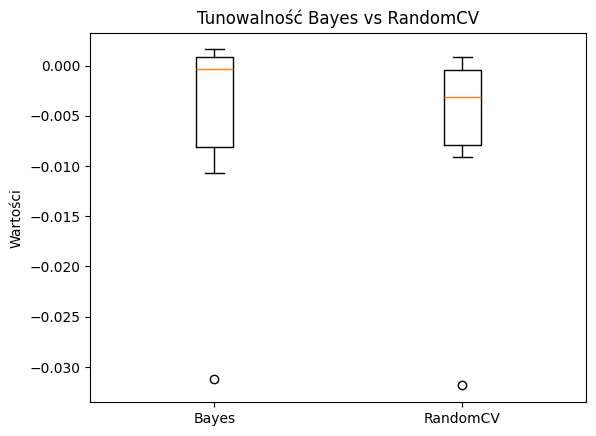

In [ ]:
import matplotlib.pyplot as plt


plt.boxplot([differences_lm_bayes,differences_lm_random_cv], labels=['Bayes', 'RandomCV'])
plt.title("Tunowalność Bayes vs RandomCV")
plt.ylabel("Wartości")
plt.show()

In [ ]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(differences_lm_bayes,differences_lm_random_cv)
print("Statystyka:", stat)
print("p-wartość:", p)

Statystyka: 5.0
p-wartość: 0.3125


### KNN

In [ ]:
knn_pipeline = Pipeline([
    ('pre',preprocessor1),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [ ]:
params_knn = {
    'knn__n_neighbors': np.arange(1,31),
    'knn__p': [1,2,3]
    }
rand_pipeline_knn = RandomizedSearchCV(
    estimator=knn_pipeline,
    param_distributions=params_knn,
    n_iter=30, # ile razy losujemy
    cv=3,
    scoring='roc_auc',
    random_state=13 # warto, zeby wyniki sie powtarzaly
)

In [ ]:
knn_random_results = {}
knn_random_best_params = {}

for idx in range(1, len(datasets) + 1):
  print(f"Starting RandomSearch for dataset X{idx}...")
  start = perf_counter()
  rand_pipeline_knn.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])
  end = perf_counter()
  print(f"RandomSearch for dataset X{idx} completed in {end - start:.2f} seconds.")

  knn_random_results[f"X{idx}"] = rand_pipeline_knn.cv_results_
  knn_random_best_params[f"X{idx}"] = rand_pipeline_knn.best_params_

Starting RandomSearch for dataset X1...
RandomSearch for dataset X1 completed in 3.40 seconds.
Starting RandomSearch for dataset X2...
RandomSearch for dataset X2 completed in 8.59 seconds.
Starting RandomSearch for dataset X3...
RandomSearch for dataset X3 completed in 3.58 seconds.
Starting RandomSearch for dataset X4...
RandomSearch for dataset X4 completed in 131.24 seconds.
Starting RandomSearch for dataset X5...
RandomSearch for dataset X5 completed in 5.92 seconds.
Starting RandomSearch for dataset X6...
RandomSearch for dataset X6 completed in 3.11 seconds.


In [ ]:
knn_random_results_full = []
for idx in range(1, len(dataframes)):
  knn_random_results_full.append(knn_random_results[f"X{idx}"]["mean_test_score"])
knn_random_means = np.mean(knn_random_results_full, axis=0)

In [ ]:
knn_theta = knn_random_results["X1"]['params'][np.argmax(knn_random_means)]

### Optymalizacja bayesowska dla KNN

In [ ]:
def objective(trial, X, y, base_pipeline):
    knn_n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    knn_p = trial.suggest_int("p", 1, 3)

    pipeline = clone(base_pipeline)

    pipeline.set_params(knn__n_neighbors = knn_n_neighbors, knn__p = knn_p)

    scores = cross_val_score(pipeline, X, y, cv=3, scoring="roc_auc", n_jobs=-1)
    return scores.mean()

studies_knn = {}
results_knn = {}

for idx in range(1, len(data_train) + 1):
    print(f"Starting Optuna study for dataset X{idx}...")
    start = perf_counter()
    study = optuna.create_study(direction="maximize", study_name=f"knn_optuna_{idx}")

    study.optimize(lambda trial: objective(trial, data_train[f"X{idx}"], targets_train[f"y{idx}"], knn_pipeline), n_trials=60)
    end = perf_counter()
    print(f"Optuna study for dataset X{idx} completed in {end - start:.1f} seconds.")

    studies_knn[f"knn_study_{idx}"] = study
    results_knn[f"knn_best_params_{idx}"] = study.best_params

Starting Optuna study for dataset X1...
Optuna study for dataset X1 completed in 9.6 seconds.
Starting Optuna study for dataset X2...
Optuna study for dataset X2 completed in 10.9 seconds.
Starting Optuna study for dataset X3...
Optuna study for dataset X3 completed in 6.6 seconds.
Starting Optuna study for dataset X4...
Optuna study for dataset X4 completed in 71.0 seconds.
Starting Optuna study for dataset X5...
Optuna study for dataset X5 completed in 17.1 seconds.
Starting Optuna study for dataset X6...
Optuna study for dataset X6 completed in 5.7 seconds.


In [ ]:
scores_knn = []
for names,vals in results_knn.items():
  tmp = []
  p= vals['p']
  n_neighbors = vals['n_neighbors']
  knn_pipeline = Pipeline([
    ('pre',preprocessor1),
    ('knn', KNeighborsClassifier(n_neighbors=n_neighbors,p=p))
])
  for idx in range(1, len(datasets) + 1):
        knn_pipeline.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])
        y_pred = knn_pipeline.predict_proba(data_test[f"X{idx}"])[:, 1]
        tmp.append(roc_auc_score(targets_test[f"y{idx}"], y_pred))
  scores_knn.append(np.mean(tmp))
best_params_name = list(results_knn.keys())[np.argmax(scores_knn)]
knn_bayes_theta = results_knn[best_params_name]

In [ ]:
differences_knn_random_cv = []
differences_knn_bayes = []

In [ ]:
for idx in range(1, len(data_train) + 1):

  knn_pipeline1 = Pipeline([
      ('pre',preprocessor1),
      ('knn', KNeighborsClassifier(n_neighbors=knn_random_best_params[f"X{idx}"]['knn__n_neighbors'],p=knn_random_best_params[f"X{idx}"]['knn__p']))
  ])
  knn_pipeline1.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])
  knn_pipeline2 = Pipeline([
        ('pre',preprocessor1),
        ('knn', KNeighborsClassifier(n_neighbors=knn_theta['knn__n_neighbors'],p=knn_theta['knn__p']))
        ])

  knn_pipeline2.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])

  d=roc_auc_score(targets_test[f"y{idx}"], knn_pipeline2.predict_proba(data_test[f"X{idx}"])[:, 1]) - roc_auc_score(targets_test[f"y{idx}"], knn_pipeline1.predict_proba(data_test[f"X{idx}"])[:, 1])
  differences_knn_random_cv.append(d)


  knn_pipeline3 = Pipeline([
      ('pre',preprocessor1),
      ('knn', KNeighborsClassifier(n_neighbors=results_knn[f'knn_best_params_{idx}']['n_neighbors'],p=results_knn[f'knn_best_params_{idx}']['p']))
  ])
  knn_pipeline3.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])

  knn_pipeline4 = Pipeline([
      ('pre',preprocessor1),
      ('knn', KNeighborsClassifier(n_neighbors=knn_bayes_theta['n_neighbors'],p=knn_bayes_theta['p']))
      ])

  knn_pipeline4.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])

  d1=roc_auc_score(targets_test[f"y{idx}"], knn_pipeline4.predict_proba(data_test[f"X{idx}"])[:, 1]) - roc_auc_score(targets_test[f"y{idx}"], knn_pipeline3.predict_proba(data_test[f"X{idx}"])[:, 1])
  differences_knn_bayes.append(d1)

In [ ]:
differences_knn_random_cv, differences_knn_bayes

([np.float64(0.00054112554112562),
  np.float64(-0.015512265512265477),
  np.float64(0.0),
  np.float64(0.0002095187684706401),
  np.float64(-0.0008720930232558599),
  np.float64(-0.011303744798890514)],
 [np.float64(0.0),
  np.float64(-0.015295815295815363),
  np.float64(0.0030487804878049918),
  np.float64(-0.001201976092805812),
  np.float64(-0.014437984496124101),
  np.float64(0.0009015256588070786)])

In [ ]:
np.mean(differences_knn_random_cv), np.mean(differences_knn_bayes)

(np.float64(-0.004489576504135932), np.float64(-0.004497578289688868))

In [ ]:
np.std(differences_knn_random_cv), np.std(differences_knn_bayes)

(np.float64(0.006436413414955831), np.float64(0.007445363843210528))

In [ ]:
stat, p = wilcoxon(differences_knn_bayes,differences_knn_random_cv)
print("Statystyka:", stat)
print("p-wartość:", p)

Statystyka: 10.0
p-wartość: 1.0


/tmp/ipython-input-3920216023.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([differences_knn_bayes,differences_knn_random_cv], labels=['Bayes', 'RandomCV'])


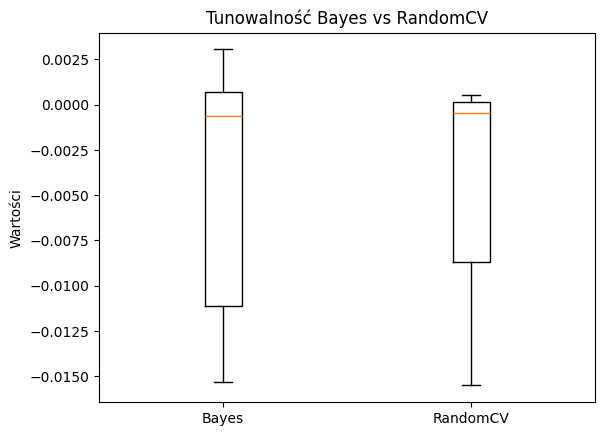

In [ ]:
plt.boxplot([differences_knn_bayes,differences_knn_random_cv], labels=['Bayes', 'RandomCV'])
plt.title("Tunowalność Bayes vs RandomCV")
plt.ylabel("Wartości")
plt.show()

### Random Forest

In [ ]:
rf_pipeline = Pipeline([
    ('pre',preprocessor1),
    ('rf', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None, max_samples=None))
])

In [ ]:
params_rf = {
    'rf__n_estimators': np.arange(1,2000,50),
    'rf__criterion': ['gini','entropy'],
    'rf__max_samples': np.linspace(0.1,1,20),
    'rf__max_features': np.linspace(0.1,1,20),
    'rf__min_samples_leaf': np.arange(1,2000,25)
    }
rand_pipeline_rf = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=params_rf,
    n_iter=30, # ile razy losujemy
    cv=3,
    scoring='roc_auc',
    random_state=13 # warto, zeby wyniki sie powtarzaly
)

In [ ]:
rf_random_results = {}
rf_random_best_params = {}

for idx in range(1, len(datasets) + 1):
  print(f"Starting RandomSearch for dataset X{idx}...")
  start = perf_counter()
  rand_pipeline_rf.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])
  end = perf_counter()
  print(f"RandomSearch for dataset X{idx} completed in {end - start:.2f} seconds.")

  rf_random_results[f"X{idx}"] = rand_pipeline_rf.cv_results_
  rf_random_best_params[f"X{idx}"] = rand_pipeline_rf.best_params_

Starting RandomSearch for dataset X1...
RandomSearch for dataset X1 completed in 128.17 seconds.
Starting RandomSearch for dataset X2...
RandomSearch for dataset X2 completed in 114.02 seconds.
Starting RandomSearch for dataset X3...
RandomSearch for dataset X3 completed in 110.87 seconds.
Starting RandomSearch for dataset X4...
RandomSearch for dataset X4 completed in 129.70 seconds.
Starting RandomSearch for dataset X5...
RandomSearch for dataset X5 completed in 111.06 seconds.
Starting RandomSearch for dataset X6...
RandomSearch for dataset X6 completed in 108.22 seconds.


In [ ]:
rf_random_results_full = []
for idx in range(1, len(dataframes)):
  rf_random_results_full.append(rf_random_results[f"X{idx}"]["mean_test_score"])
rf_random_means = np.mean(rf_random_results_full, axis=0)

In [ ]:
rf_theta = rf_random_results["X1"]['params'][np.argmax(rf_random_means)]

### Optymalizacja bayesowka dla Random Forest

In [ ]:
def objective(trial, X, y, base_pipeline):
    rf_n_estimators= trial.suggest_int("n_estimators",1,2000)
    rf_criterion = trial.suggest_categorical('criterion',['gini','entropy'])
    rf_max_samples = trial.suggest_float('max_samples',0.1,1)
    rf_max_features = trial.suggest_float('max_features',0.1,1)
    rf_min_samples_leaf= trial.suggest_int('min_samples_leaf',1,2000)


    pipeline = clone(base_pipeline)

    pipeline.set_params(rf__n_estimators=rf_n_estimators, rf__criterion=rf_criterion, rf__max_samples=rf_max_samples, rf__max_features=rf_max_features, rf__min_samples_leaf=rf_min_samples_leaf)

    scores = cross_val_score(pipeline, X, y, cv=3, scoring="roc_auc", n_jobs=-1)
    return scores.mean()

studies_rf = {}
results_rf = {}

for idx in range(1, len(data_train) + 1):
    print(f"Starting Optuna study for dataset X{idx}...")
    start = perf_counter()
    study = optuna.create_study(direction="maximize", study_name=f"rf_optuna_{idx}")

    study.optimize(lambda trial: objective(trial, data_train[f"X{idx}"], targets_train[f"y{idx}"], rf_pipeline), n_trials=60)
    end = perf_counter()
    print(f"Optuna study for dataset X{idx} completed in {end - start:.1f} seconds.")

    studies_rf[f"rf_study_{idx}"] = study
    results_rf[f"rf_best_params_{idx}"] = study.best_params

Starting Optuna study for dataset X1...
Optuna study for dataset X1 completed in 340.2 seconds.
Starting Optuna study for dataset X2...
Optuna study for dataset X2 completed in 380.7 seconds.
Starting Optuna study for dataset X3...
Optuna study for dataset X3 completed in 153.3 seconds.
Starting Optuna study for dataset X4...
Optuna study for dataset X4 completed in 270.1 seconds.
Starting Optuna study for dataset X5...
Optuna study for dataset X5 completed in 258.3 seconds.
Starting Optuna study for dataset X6...
Optuna study for dataset X6 completed in 324.3 seconds.


In [ ]:
scores_rf = []
for names,vals in results_rf.items():
  tmp = []
  n_estimators = vals['n_estimators']
  criterion = vals['criterion']
  max_samples = vals['max_samples']
  max_features = vals['max_features']
  min_samples_leaf= vals['min_samples_leaf']
  rf_pipeline = Pipeline([
    ('pre',preprocessor1),
    ('rf', RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_leaf=min_samples_leaf, max_samples=max_samples,max_features=max_features))
])
  for idx in range(1, len(datasets) + 1):
        rf_pipeline.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])
        y_pred = rf_pipeline.predict_proba(data_test[f"X{idx}"])[:, 1]
        tmp.append(roc_auc_score(targets_test[f"y{idx}"], y_pred))
  scores_rf.append(np.mean(tmp))
best_params_name = list(results_rf.keys())[np.argmax(scores_rf)]
rf_bayes_theta = results_rf[best_params_name]

In [ ]:
differences_rf_random_cv = []
differences_rf_bayes = []

In [ ]:
for idx in range(1, len(data_train) + 1):


  rf_pipeline1 = Pipeline([
    ('pre',preprocessor1),
    ('rf', RandomForestClassifier(n_estimators=rf_random_best_params[f"X{idx}"]['rf__n_estimators'],
                                  criterion=rf_random_best_params[f"X{idx}"]['rf__criterion'],
                                  min_samples_leaf=rf_random_best_params[f"X{idx}"]['rf__min_samples_leaf'],
                                  max_samples=rf_random_best_params[f"X{idx}"]['rf__max_samples'],
                                  max_features=rf_random_best_params[f"X{idx}"]['rf__max_features']))
  ])
  rf_pipeline1.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])

  rf_pipeline2 = Pipeline([
      ('pre',preprocessor1),
      ('rf', RandomForestClassifier(n_estimators=rf_theta['rf__n_estimators'],
                                    criterion=rf_theta['rf__criterion'],
                                    min_samples_leaf=rf_theta['rf__min_samples_leaf'],
                                    max_samples=rf_theta['rf__max_samples'],
                                    max_features=rf_theta['rf__max_features']))
      ])

  rf_pipeline2.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])
  d=roc_auc_score(targets_test[f"y{idx}"], rf_pipeline2.predict_proba(data_test[f"X{idx}"])[:, 1]) - roc_auc_score(targets_test[f"y{idx}"], rf_pipeline1.predict_proba(data_test[f"X{idx}"])[:, 1])
  differences_rf_random_cv.append(d)

  rf_pipeline3 = Pipeline([
      ('pre',preprocessor1),
      ('rf', RandomForestClassifier(n_estimators=results_rf[f'rf_best_params_{idx}']['n_estimators'],
                                    criterion=results_rf[f'rf_best_params_{idx}']['criterion'],
                                    min_samples_leaf=results_rf[f'rf_best_params_{idx}']['min_samples_leaf'],
                                    max_samples=results_rf[f'rf_best_params_{idx}']['max_samples'],
                                    max_features=results_rf[f'rf_best_params_{idx}']['max_features']))
  ])
  rf_pipeline3.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])

  rf_pipeline4 = Pipeline([
      ('pre',preprocessor1),
      ('rf', RandomForestClassifier(n_estimators=rf_bayes_theta['n_estimators'],
                                    criterion=rf_bayes_theta['criterion'],
                                    min_samples_leaf=rf_bayes_theta['min_samples_leaf'],
                                    max_samples=rf_bayes_theta['max_samples'],
                                    max_features=rf_bayes_theta['max_features']))
      ])

  rf_pipeline4.fit(data_train[f"X{idx}"], targets_train[f"y{idx}"])


  d1=roc_auc_score(targets_test[f"y{idx}"], rf_pipeline4.predict_proba(data_test[f"X{idx}"])[:, 1]) - roc_auc_score(targets_test[f"y{idx}"], rf_pipeline3.predict_proba(data_test[f"X{idx}"])[:, 1])
  differences_rf_bayes.append(d1)

In [ ]:
differences_rf_bayes

[np.float64(-0.003727753727753691),
 np.float64(0.010101010101010166),
 np.float64(0.03590785907859073),
 np.float64(-0.0041005816114986215),
 np.float64(-0.0034883720930233286),
 np.float64(0.007350901525658982)]

In [ ]:
differences_rf_random_cv

[np.float64(0.04407166907166904),
 np.float64(0.05887445887445897),
 np.float64(0.2632113821138211),
 np.float64(-0.025890533532455073),
 np.float64(-9.689922480626834e-05),
 np.float64(-0.06456310679611654)]

In [ ]:
np.mean(differences_rf_random_cv), np.mean(differences_rf_bayes)

(np.float64(0.04593449508442854), np.float64(0.00700717721216404))

In [ ]:
np.std(differences_rf_random_cv), np.std(differences_rf_bayes)

(np.float64(0.10556798949811473), np.float64(0.014105063891378845))

In [ ]:
stat, p = wilcoxon(differences_rf_bayes,differences_rf_random_cv)
print("Statystyka:", stat)
print("p-wartość:", p)

Statystyka: 7.0
p-wartość: 0.5625


/tmp/ipython-input-1326802150.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([differences_rf_bayes,differences_rf_random_cv], labels=['Bayes', 'RandomCV'])


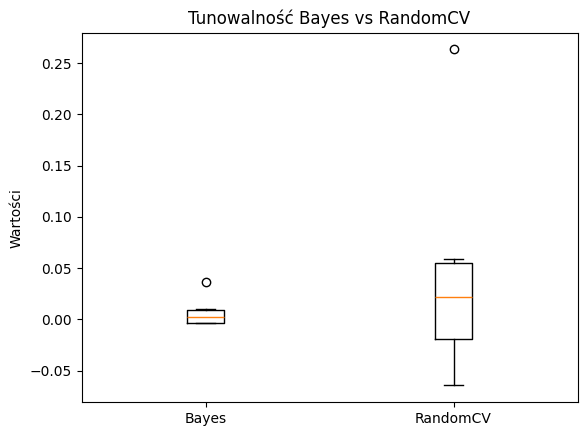

In [ ]:
plt.boxplot([differences_rf_bayes,differences_rf_random_cv], labels=['Bayes', 'RandomCV'])
plt.title("Tunowalność Bayes vs RandomCV")
plt.ylabel("Wartości")
plt.show()

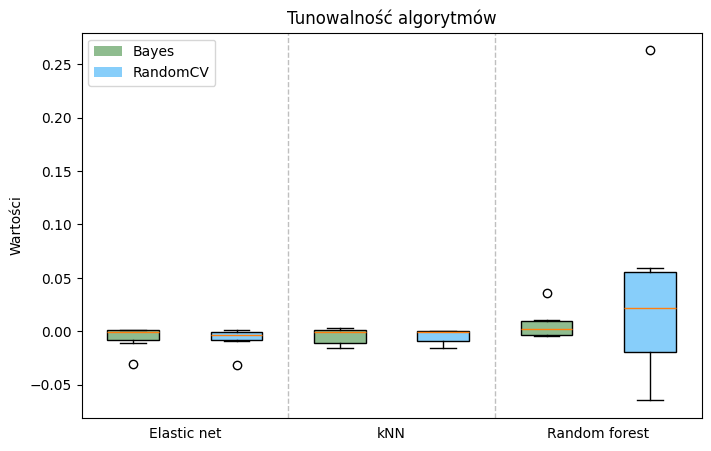

In [ ]:
from matplotlib.patches import Patch

plt.figure(figsize=(8, 5))

bp = plt.boxplot([differences_lm_bayes, differences_lm_random_cv,
             differences_knn_bayes, differences_knn_random_cv,
             differences_rf_bayes,differences_rf_random_cv],
             patch_artist=True, medianprops=dict(color='red')
                 )

box_colors = ["darkseagreen", "lightskyblue", "darkseagreen", "lightskyblue", "darkseagreen", "lightskyblue"]

for box, color in zip(bp["boxes"], box_colors):
    box.set_facecolor(color)

legend = [Patch(facecolor="darkseagreen", label="Bayes"),
                   Patch(facecolor="lightskyblue",  label="RandomCV")]

plt.xticks([])

for x in [2.5, 4.5]:
    plt.axvline(x=x, color='gray', linestyle='--', alpha = 0.5, lw = 1)

plt.text(1.5, -0.1, "Elastic net", ha='center')
plt.text(3.5, -0.1, "kNN", ha='center')
plt.text(5.5, -0.1, "Random forest", ha='center')

plt.legend(handles=legend)

plt.title("Tunowalność algorytmów")
plt.ylabel("Wartości")
plt.show()